In [3]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from Helpers.Grae import get_GRAE_networks, BaseDataset


In [33]:

"""
This script pulls in one of Marshall's embeddings to validate how well it predicts the test points embedded by GRAE
"""

import sys
sys.path.append('/yunity/msn39/ADNI-Modeling-Dashboard')  # So we can get to the ADNI Dataset class
import ADNI_Dataset_Class


# Define the path to the pickle file
file_path = os.path.join('Datasets', 'Embeddings', 'your_pickle_file.pkl')

# Load the pickle files for the desired manifold alignment, embeddings, and dataset objects

folder_name = os.listdir("/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/")[0]
emb_folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/" + folder_name

emb_folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/MASH_FAQ Variables 2025-03-08-08-13_DX_DX2_use_rf_proximities_selection-ADNI3_2025-Mar-17-@-10-11_DCB Variables 2025-03-05-14-47_DX_DX2_use_rf_proximities_selection-ADNI3_2025-Mar-17-@-10-11_2025-Mar-17-@-10-24"

with open(emb_folder + '/class_object.pkl', 'rb') as file:
    mash_object = pickle.load(file)
with open(emb_folder + '/domain_object_1.pkl', 'rb') as file:
    domain_1_object = pickle.load(file)
with open(emb_folder + '/domain_object_2.pkl', 'rb') as file:
    domain_2_object = pickle.load(file)

In [35]:
graeA, graeB = get_GRAE_networks(domain_1_object.data, domain_2_object.data, mash_object.emb, n_comp = 2, 
                  anchors = mash_object.known_anchors, labelsA = domain_1_object.labels, labelsB = domain_2_object.labels)

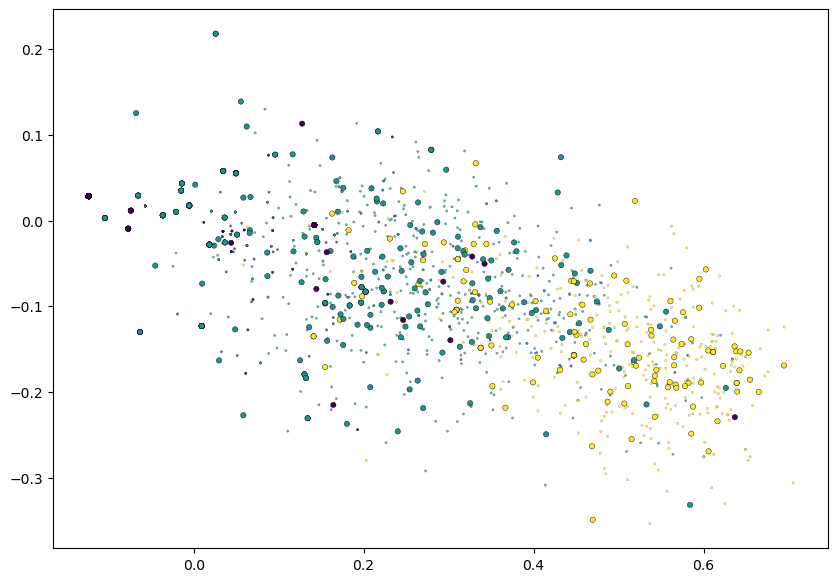

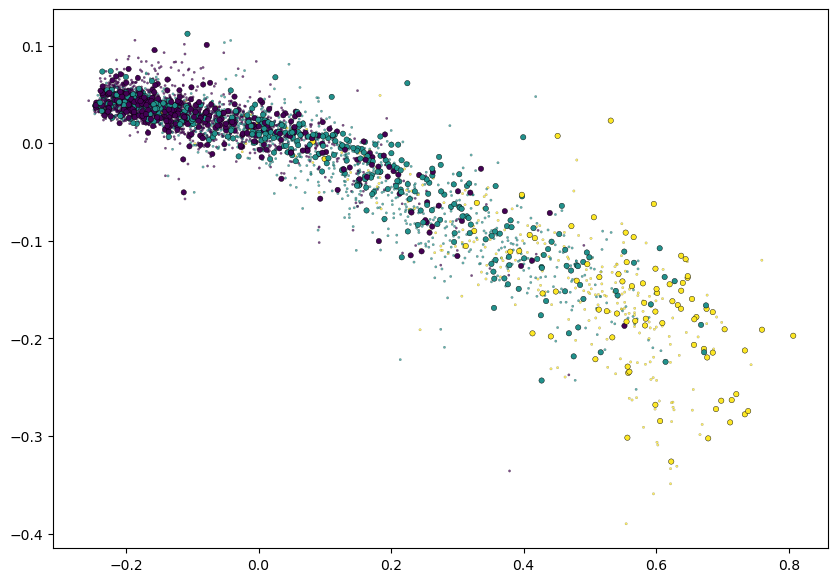

In [36]:
A_X_train_grae = BaseDataset(domain_1_object.data, np.array(domain_1_object.labels), split="none", split_ratio=0.8, random_state=42)
B_X_train_grae = BaseDataset(domain_2_object.data, np.array(domain_2_object.labels), split="none", split_ratio=0.8, random_state=42)

A_X_val_grae = BaseDataset(domain_1_object.val_data, np.array(domain_1_object.val_labels), split="none", split_ratio=0.8, random_state=42)
B_X_val_grae = BaseDataset(domain_2_object.val_data, np.array(domain_2_object.val_labels), split="none", split_ratio=0.8, random_state=42)

graeA.plot(A_X_train_grae, A_X_val_grae, cmap="viridis")
graeB.plot(B_X_train_grae, B_X_val_grae, cmap="viridis")

In [37]:
# See how accurate it is on the test points
new_embedded_points_A = graeA.transform(A_X_val_grae)
new_embedded_points_B = graeB.transform(B_X_val_grae)

# Create a model to predict labels based on embedding points
X_train = mash_object.emb
y_train = pd.concat([domain_1_object.labels, domain_2_object.labels])
embedding_based_model = RandomForestClassifier(n_estimators=100, random_state=42)
embedding_based_model.fit(X_train, y_train)

# Predict on the test sets
predictions_A = embedding_based_model.predict(new_embedded_points_A)
predictions_B = embedding_based_model.predict(new_embedded_points_B)

# Evaluate accuracy
accuracy_A = accuracy_score(domain_1_object.val_labels, predictions_A)
accuracy_B = accuracy_score(domain_2_object.val_labels, predictions_B)


# Print all accuracy scores
domain_1_dataset_score = domain_1_object.dataset_accuracy
domain_1_distances_score = domain_1_object.distances_accuracy
domain_2_dataset_score = domain_2_object.dataset_accuracy
domain_2_distances_score = domain_2_object.distances_accuracy
manifold_oob = mash_object.get_scores(labels=y_train, n_jobs=-1)

print(f"Beginning FAQ Score: {domain_1_dataset_score}")
print(f"Beginning Dataset ADAS Score: {domain_2_dataset_score}")
print(f"Practical Test Accuracy FAQ: {accuracy_A:.4f}")
print(f"Practical Test Accuracy ADAS: {accuracy_B:.4f}")

RF-GAP score is R^2
Calculating the R squared score.
Beginning FAQ Score: 0.7258566978193146
Beginning Dataset ADAS Score: 0.635890767230169
Practical Test Accuracy FAQ: 0.6989
Practical Test Accuracy ADAS: 0.6320


In [38]:
def denormalize_data(normalized_data, min_vals, max_vals):
    if isinstance(normalized_data, np.ndarray):
        return normalized_data * (max_vals - min_vals) + min_vals
    
    elif isinstance(normalized_data, pd.DataFrame):
        return normalized_data * (max_vals - min_vals) + min_vals
    
    else:
        raise ValueError("Input should be a NumPy array or a Pandas DataFrame.")
    
B_transformed_to_A = graeA.inverse_transform(new_embedded_points_B)
A_transformed_to_B = graeB.inverse_transform(new_embedded_points_A)

B_transformed_to_A = denormalize_data(B_transformed_to_A, domain_1_object.val_min_vals, domain_1_object.val_max_vals)
A_transformed_to_B = denormalize_data(A_transformed_to_B, domain_2_object.val_min_vals, domain_2_object.val_max_vals)

original_A = denormalize_data(domain_1_object.val_data, domain_1_object.val_min_vals, domain_1_object.val_max_vals)
original_B = denormalize_data(domain_2_object.val_data, domain_2_object.val_min_vals, domain_2_object.val_max_vals)

In [41]:
original_A_df = pd.DataFrame(original_A)
original_A_df['RID'] = list(domain_1_object.val_rids)
original_A_df['VISMONTH'] = list(domain_1_object.val_vismonth)

original_B_df = pd.DataFrame(original_B)
original_B_df['RID'] = list(domain_2_object.val_rids)
original_B_df['VISMONTH'] = list(domain_2_object.val_vismonth)

In [42]:
#they don't automatically line up by the same RIDs so we're going to need to fix that

B_transformed_to_A_df = pd.DataFrame(B_transformed_to_A)
B_transformed_to_A_df['RID'] = list(domain_2_object.val_rids)
B_transformed_to_A_df['VISMONTH'] = list(domain_2_object.val_vismonth)
A_transformed_to_B_df = pd.DataFrame(A_transformed_to_B)
A_transformed_to_B_df['RID'] = list(domain_1_object.val_rids)
A_transformed_to_B_df['VISMONTH'] = list(domain_1_object.val_vismonth)

In [43]:
domain_1_object.variables

['FAQFINAN',
 'FAQFORM',
 'FAQSHOP',
 'FAQGAME',
 'FAQBEVG',
 'FAQMEAL',
 'FAQEVENT',
 'FAQTV',
 'FAQREM',
 'FAQTRAVL',
 'FAQTOTAL']

In [44]:
domain_2_object.variables

['N1', 'N2', 'N3', 'N4', 'R1', 'R2', 'R3', 'M1', 'M2', 'M3']

In [51]:
from sklearn.metrics import mean_squared_error

# Merge the dataframes on 'RID' and 'VISMONTH'
merged_df = pd.merge(B_transformed_to_A_df, original_A_df, on=['RID', 'VISMONTH'], suffixes=('_transformed', '_original'))

# Calculate the MSE by column
column_mse = []
transformed_array = merged_df.filter(regex='_transformed$').values
original_array = merged_df.filter(regex='_original$').values
for col in range(transformed_array.shape[1]):
    mse_value = mean_squared_error(transformed_array[:, col], original_array[:, col])
    column_mse.append(mse_value)

# Create a table so we can look at things
mins = list(domain_1_object.test_min_vals)
maxes = list(domain_1_object.test_max_vals)
column_rmse = np.sqrt(column_mse)
var_names = list(domain_1_object.variables)
viewing_dict = {'Variable': var_names, 'Min': mins, 'Max': maxes, 'MSE': column_mse, 'RMSE': column_rmse}
viewing_df = pd.DataFrame(viewing_dict)
print(f"Using {domain_2_object.type} data to predict {domain_1_object.type} data")
print(viewing_df)

Using dcb data to predict faq data
    Variable  Min  Max        MSE      RMSE
0   FAQFINAN    0    3   0.465886  0.682558
1    FAQFORM    0    3   0.511854  0.715440
2    FAQSHOP    0    3   0.380636  0.616957
3    FAQGAME    0    3   0.360106  0.600088
4    FAQBEVG    0    3   0.267133  0.516850
5    FAQMEAL    0    3   0.366490  0.605384
6   FAQEVENT    0    3   0.394209  0.627860
7      FAQTV    0    3   0.250043  0.500043
8     FAQREM    0    3   0.607590  0.779481
9   FAQTRAVL    0    3   0.484872  0.696327
10  FAQTOTAL    0   30  23.448166  4.842331


In [ ]:
# Merge the dataframes on 'RID' and 'VISMONTH'
merged_df_B = pd.merge(A_transformed_to_B_df, original_B_df, on=['RID', 'VISMONTH'], suffixes=('_transformed', '_original'))

# Calculate the MSE by column
column_mse = []
transformed_array = merged_df_B.filter(regex='_transformed$').values
original_array = merged_df_B.filter(regex='_original$').values
for col in range(transformed_array.shape[1]):
    mse_value = mean_squared_error(transformed_array[:, col], original_array[:, col])
    column_mse.append(mse_value)

# Create a table so we can look at things
mins = list(domain_2_object.test_min_vals)
maxes = list(domain_2_object.test_max_vals)
column_rmse = np.sqrt(column_mse)
var_names = list(domain_2_object.variables)
viewing_dict = {'Variable': var_names, 'Min': mins, 'Max': maxes, 'MSE': column_mse, 'RMSE': column_rmse}
viewing_df = pd.DataFrame(viewing_dict)
print(f"Using {domain_1_object.type} data to predict {domain_2_object.type} data")
print(viewing_df)

Using faq data to predict dcb data
  Variable       Min       Max       MSE      RMSE
0       N1  0.076335  0.598954  0.007264  0.085228
1       N2  0.265059  0.656898  0.006860  0.082828
2       N3  0.179960  0.743701  0.011377  0.106662
3       N4  0.137190  0.464948  0.005376  0.073320
4       R1  0.219107  0.453065  0.001148  0.033885
5       R2  0.426445  0.945277  0.005682  0.075381
6       R3  0.366259  0.781131  0.006010  0.077524
7       M1  0.430212  0.925556  0.005542  0.074447
8       M2  0.331881  0.946900  0.007714  0.087829
9       M3  0.238676  0.735580  0.008690  0.093222


In [58]:
# Give me an example of the kinds of predictions that we're talking about
three_random_indicies = np.random.choice(merged_df.index, 3, replace=False)
print(merged_df.loc[three_random_indicies])

     0_transformed  1_transformed  2_transformed  3_transformed  \
443      -0.058409      -0.066176       0.014706       0.008476   
717       1.267871       1.515646       0.799487       0.685680   
458      -0.079664      -0.106078       0.012266       0.021495   

     4_transformed  5_transformed  6_transformed  7_transformed  \
443       0.013365       0.020803      -0.004359       0.004658   
717       0.424740       0.830285       0.856684       0.617221   
458       0.028633       0.018391      -0.016878       0.016955   

     8_transformed  9_transformed  ...  1_original  2_original  3_original  \
443      -0.112627       0.032974  ...         0.0         0.0         0.0   
717       1.337106       1.057189  ...         1.0         3.0         2.0   
458      -0.186668       0.046804  ...         0.0         0.0         0.0   

     4_original  5_original  6_original  7_original  8_original  9_original  \
443         0.0         0.0         0.0         0.0         0.0       